In [1]:
import pygsti
from pygsti.extras import rb
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as _np
from pygsti.construction import std1Q_XYI
from scipy.optimize import curve_fit
import time
import pickle
import sys
sys.path.append('../ExperimentalData/')
from Cliffs_to_prims import cliff_to_prims

In [2]:
RBData = pygsti.io.load_dataset('../ExperimentalData/2015_03_30-RB_0320_condensed_cliffs.txt',cache=True,collisionAction='keepseparate')

Loading from cache file: ../ExperimentalData/2015_03_30-RB_0320_condensed_cliffs.txt.cache


In [3]:
gs_clifford_target_48 = pygsti.construction.build_alias_gateset(std1Q_XYI.gs_target,cliff_to_prims)

In [4]:
cliff_seq_file = open('../ExperimentalData/Cliff_seqs.txt','r')
cliff_seq_lines = cliff_seq_file.readlines()
cliff_seq_file.close()

cliff_seqs = []
for line in cliff_seq_lines:
    seq = eval(line.split(' ')[1])
    cliff_seqs.append(pygsti.objects.gatestring.GateString(seq))

In [5]:
#Analyze the experimental RB data.
rb_exp_results = rb.do_randomized_benchmarking(RBData, cliff_seqs,pre_avg=True,
                                           success_spamlabel='minus', dim=2,
                                           clifford_to_primitive = cliff_to_prims)

In [6]:
#Compute bootstrapped error bars for the experimental RB results.
rb_exp_results.compute_bootstrap_error_bars(seed=0)

Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-param

In [7]:
#Load in the GST estimate of the gate set.
GSTResults = pickle.load(open('../ComputedObjects/2015_03_30-GST_BB1_XYXY_8192_condensed.pkl','r'))
gsGST = GSTResults.gatesets['final estimate']

In [8]:
#Generate simulated RB data, using the GST fit for the underlying gate set.
GSTRBData = pygsti.construction.generate_fake_data(gsGST,cliff_seqs,285,sampleError='binomial',seed=0,aliasDict=cliff_to_prims,collisionAction='keepseparate')

In [9]:
#Analyze the simulated "GST RB" dataset.
rb_gst_results = rb.do_randomized_benchmarking(GSTRBData, cliff_seqs,pre_avg=True,
                                           success_spamlabel='minus', dim=2,
                                           clifford_to_primitive = cliff_to_prims)

In [10]:
#To get error bars on the rb_gst_results, we use a *parametric* bootstrap.  The bootstrapped gate sets have already
#been generated, although you can generate them yourself if you so desire, using the notebook
#"GenerateBootstrappedGateSets.ipynb".  Running said notebook may take many hours and is thus not recommended.

bootstrapped_gs_list = []
for i in xrange(100):
    gs = pygsti.io.load_gateset('../ComputedObjects/GST_Bootstrap-8192_10-20-16/gateset_parametric_logl_'+str(i)+'.gateset')
    bootstrapped_gs_list.append(gs)

rb_cliff_r_list = []
rb_prim_r_list = []
start = time.time()
for i, bootstrapped_gs in enumerate(bootstrapped_gs_list):
    print i
    temp_data = pygsti.construction.generate_fake_data(bootstrapped_gs,cliff_seqs,285,sampleError='binomial',seed=0,aliasDict=cliff_to_prims,collisionAction='keepseparate')
    rb_results = rb.do_randomized_benchmarking(temp_data,cliff_seqs,pre_avg=True,success_spamlabel='minus',
                                              dim=2,clifford_to_primitive=cliff_to_prims)
    rb_cliff_r_list.append(rb_results.dicts['clifford']['r'])
    rb_prim_r_list.append(rb_results.dicts['primitive']['r'])
end = time.time()
print end - start

0


/home/kmrudin/pyGSTi/packages/pygsti/construction/datasetconstruction.py:124: UserWarning: Adjusting sum(probs) > 1 to 1
  if psum > 1+TOL: _warnings.warn("Adjusting sum(probs) > 1 to 1")


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
3641.76660395


In [13]:
#Compute error bars for the "GST RB" number.

rb_cliff_r_error = 2*_np.std(rb_cliff_r_list,ddof=1)
rb_prim_r_error = 2*_np.std(rb_cliff_r_list,ddof=1)

In [14]:
#Now we create a non-Markovian gate set which we will use to generate RB data.
gs_base = gsGST.copy()
theta = 1.25e-2
gs_underRotX = gs_base.rotate( (-theta,0,0) )
gs_overRotX  = gs_base.rotate( (+theta,0,0) )
gs_underRotY = gs_base.rotate( (0,-theta,0) )
gs_overRotY  = gs_base.rotate( (0,+theta,0) )

hh = _np.array([[0.5],[0.5]], 'd')
oo = _np.array([[1.0],[1.0]], 'd')
envSwich = _np.kron( _np.array([[0,1],[1,0]], 'd'), _np.identity(4, 'd') )

idMag = _np.sqrt(2)
gs_augmented = pygsti.obj.GateSet()
gs_augmented['rho'] = _np.kron(hh,gs_base['rho0'])
gs_augmented['E']   = _np.kron(oo,gs_base['E0'])
gs_augmented['identity'] = _np.array([idMag,0,0,0,idMag,0,0,0], 'd')[:,None]
gs_augmented.spamdefs['plus'] = ('rho','E')
gs_augmented.spamdefs['minus'] = ('rho','remainder')

#I gate
gl = "Gi"
gate_matrix = _np.zeros((8,8), 'd')
gate_matrix[0:4,0:4] = gs_base[gl]
gate_matrix[4:8,4:8] = gs_base[gl]
gate_matrix = _np.dot(gate_matrix, envSwich) #compose with environment switching
gs_augmented[gl] = gate_matrix

#X gate
gl = "Gx"
gate_matrix = _np.zeros((8,8), 'd')
gate_matrix[0:4,0:4] = gs_underRotX[gl]
gate_matrix[4:8,4:8] = gs_overRotX[gl]
gate_matrix = _np.dot(gate_matrix, envSwich) #compose with environment switching
gs_augmented[gl] = gate_matrix

#Y gate
gl = "Gy"
gate_matrix = _np.zeros((8,8), 'd')
gate_matrix[0:4,0:4] = gs_underRotY[gl]
gate_matrix[4:8,4:8] = gs_overRotY[gl]
gate_matrix = _np.dot(gate_matrix, envSwich) #compose with environment switching
gs_augmented[gl] = gate_matrix

In [15]:
#Now we generate simulated non-Markovian RB data.
NonMarkovRBData = pygsti.construction.generate_fake_data(gs_augmented,cliff_seqs,285,sampleError='binomial',seed=0,aliasDict=cliff_to_prims,collisionAction='keepseparate')

In [16]:
#We analyze the simulated non-Markovian RB dataset.
rb_nonmarkov_results = rb.do_randomized_benchmarking(NonMarkovRBData, cliff_seqs,pre_avg=True,
                                           success_spamlabel='minus', dim=2,
                                           clifford_to_primitive = cliff_to_prims)

In [17]:
#We compute error bars for the non-Markovian RB results
rb_nonmarkov_results.compute_bootstrap_error_bars()

Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-param

In [18]:
#Let's see what the numbers are!
#GST RB error bars provided below;
#note that 1 sigma error bars are given
#for the experimental RB results
#and the simulated non-Markovian RB results.
print "Exp. RB:"
rb_exp_results.print_detail('primitive')
print "GST RB:"
rb_gst_results.print_detail('primitive')
print "Non-Markovian RB:"
rb_nonmarkov_results.print_detail('primitive')

print "Exp. RB:"
rb_exp_results.print_detail('clifford')
print "GST RB:"
rb_gst_results.print_detail('clifford')
print "Non-Markovian RB:"
rb_nonmarkov_results.print_detail('clifford')

Exp. RB:
primitive results 
  - Using zeroth order fitting function: A + B*f^m  
  - with boostrapped-derived error bars (1 sigma):
A = 0.500043635255 +/- 1.74358423185e-05
B = 0.494468998154 +/- 0.00085853859302
f = 0.999893069733 +/- 1.54730392645e-06
F_avg = 0.999946534867 +/- 7.73651963225e-07
r = 5.34651333808e-05 +/- 7.73651963225e-07

GST RB:
primitive results 
  - Using zeroth order fitting function: A + B*f^m  
A = 0.500012765632
B = 0.496885925089
f = 0.999909134776
F_avg = 0.999954567388
r = 4.54326119822e-05

Non-Markovian RB:
primitive results 
  - Using zeroth order fitting function: A + B*f^m  
  - with boostrapped-derived error bars (1 sigma):
A = 0.500035429619 +/- 1.2843012091e-05
B = 0.495560181096 +/- 0.00077623211323
f = 0.999891932227 +/- 1.29412190813e-06
F_avg = 0.999945966114 +/- 6.47060954064e-07
r = 5.40338863413e-05 +/- 6.47060954064e-07

Exp. RB:
clifford results 
  - Using zeroth order fitting function: A + B*f^m  
  - with boostrapped-derived error bars (

In [19]:
print "2 sigma error bars for GST RB number (primitive) =", rb_prim_r_error
print "2 sigma error bars for GST RB number (clifford) =", rb_cliff_r_error

2 sigma error bars for GST RB number (primitive) = 7.61421579559e-06
2 sigma error bars for GST RB number (clifford) = 7.61421579559e-06


In [20]:
#Now let's get the data points to plot for Figure 5.  Note that we compute the decay rates using the 
#standard "pre-averaging" method for each survival probability, but that we plot each individual
#sequence survival probability in Figure 5.

rb_exp_results_plot = rb.do_randomized_benchmarking(RBData, cliff_seqs,pre_avg=False,
                                           success_spamlabel='minus', dim=2,
                                           clifford_to_primitive = cliff_to_prims)

rb_gst_results_plot = rb.do_randomized_benchmarking(GSTRBData, cliff_seqs,pre_avg=False,
                                           success_spamlabel='minus', dim=2,
                                           clifford_to_primitive = cliff_to_prims)

rb_nonmarkov_results_plot = rb.do_randomized_benchmarking(NonMarkovRBData, cliff_seqs,pre_avg=False,
                                           success_spamlabel='minus', dim=2,
                                           clifford_to_primitive = cliff_to_prims)

In [21]:
prim_lengths = rb_exp_results_plot.dicts['primitive']['lengths']

rb_exp_prim_successes = rb_exp_results_plot.dicts['primitive']['successes']
rb_gst_prim_successes = rb_gst_results_plot.dicts['primitive']['successes']
rb_nonmarkov_prim_successes = rb_nonmarkov_results_plot.dicts['primitive']['successes']

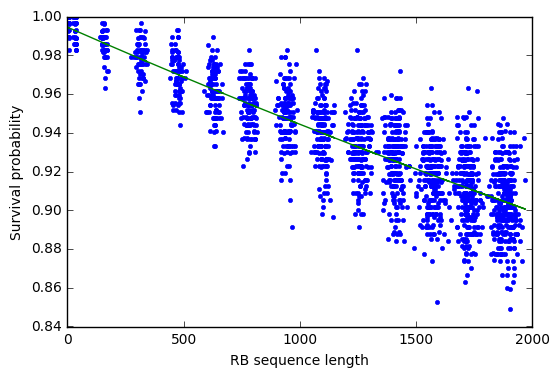

In [23]:
A,B,f = rb_exp_results.dicts['primitive']['A'],rb_exp_results.dicts['primitive']['B'],rb_exp_results.dicts['primitive']['f']
plt.plot(prim_lengths,rb_exp_prim_successes,'.')
plt.plot(prim_lengths,map(lambda x: rb.rb_decay_WF(x,A,B,f), prim_lengths),'-')
plt.xlabel('RB sequence length')
plt.ylabel('Survival probability')
plt.savefig('../Figures/Fig5a.pdf')

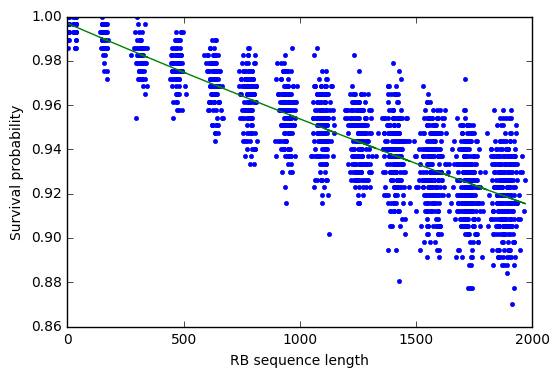

In [24]:
A,B,f = rb_gst_results.dicts['primitive']['A'],rb_gst_results.dicts['primitive']['B'],rb_gst_results.dicts['primitive']['f']
plt.plot(prim_lengths,rb_gst_prim_successes,'.')
plt.plot(prim_lengths,map(lambda x: rb.rb_decay_WF(x,A,B,f), prim_lengths),'-')
plt.xlabel('RB sequence length')
plt.ylabel('Survival probability')
plt.savefig('../Figures/Fig5b.pdf')

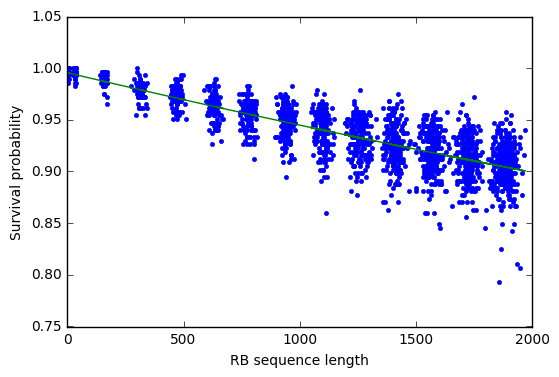

In [25]:
A,B,f = rb_nonmarkov_results.dicts['primitive']['A'],rb_nonmarkov_results.dicts['primitive']['B'],rb_nonmarkov_results.dicts['primitive']['f']
plt.plot(prim_lengths,rb_nonmarkov_prim_successes,'.')
plt.plot(prim_lengths,map(lambda x: rb.rb_decay_WF(x,A,B,f), prim_lengths),'-')
plt.xlabel('RB sequence length')
plt.ylabel('Survival probability')
plt.savefig('../Figures/Fig5c.pdf')

In [26]:
#Print data plotted above
print "Sequence length\t\tRB Exp.\t\tGST RB Sim.\t\tNon-Markovian Sim"
for i in zip(prim_lengths,rb_exp_prim_successes,rb_gst_prim_successes,rb_nonmarkov_prim_successes):
    print str(i[0])+'\t\t'+str(i[1])+'\t\t'+str(i[2])+'\t\t'+str(i[3])

Sequence length		RB Exp.		GST RB Sim.		Non-Markovian Sim
4		0.989473684211		0.99649122807		0.99649122807
4		0.99298245614		0.99298245614		0.99298245614
8		0.99649122807		0.99649122807		0.99649122807
8		0.982456140351		0.99649122807		0.99649122807
6		1.0		0.99649122807		0.99649122807
2		1.0		0.99649122807		0.99649122807
4		0.99649122807		0.99649122807		0.99649122807
4		0.99649122807		0.989473684211		0.989473684211
4		0.992592592593		0.985964912281		0.985964912281
4		1.0		0.99649122807		0.99649122807
4		0.989473684211		0.99298245614		0.99298245614
8		1.0		0.99649122807		0.99649122807
8		0.99298245614		0.99649122807		0.99649122807
4		0.989473684211		0.989473684211		0.989473684211
8		0.996296296296		1.0		1.0
6		0.989473684211		1.0		1.0
8		0.99649122807		1.0		1.0
6		0.99649122807		0.99298245614		0.99298245614
6		0.988888888889		0.99298245614		0.99298245614
6		1.0		0.989473684211		0.989473684211
32		0.988888888889		0.985964912281		0.982456140351
35		0.982456140351		0.989473684211		0.98947368

In [27]:
#Lastly, let's see how consistent GST analysis of the non-Markovian gate set is with our experimental GST analysis.
#Generate fake data based on the augmented (and non-augmented for comparison) gateset
maxLengths = [0,1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192]
seed = 1234
gateStringLists = pygsti.construction.make_lsgst_lists(gs_augmented.gates.keys(), std1Q_XYI.fiducials, std1Q_XYI.fiducials, std1Q_XYI.germs, maxLengths)
dsFakeAugmented = pygsti.construction.generate_fake_data(gs_augmented, gateStringLists[-1], nSamples=50, sampleError='binomial', seed=seed)

In [28]:
augGSTResults = pygsti.do_long_sequence_gst(dsFakeAugmented, std1Q_XYI.gs_target,
                                            std1Q_XYI.fiducials, std1Q_XYI.fiducials, std1Q_XYI.germs, maxLengths)

--- LGST ---
  Singular values of I_tilde (truncating to first 4 of 6) = 
  4.24682541884
  1.46932355083
  1.38901157544
  1.36329378472
  0.107195432906
  0.0612225767244
  
  Singular values of target I_tilde (truncating to first 4 of 6) = 
  4.24264068712
  1.41421356237
  1.41421356237
  1.41421356237
  3.03274435922e-16
  1.52179543682e-16
  
--- Iterative MLGST: Iter 01 of 15  92 gate strings ---: 
  --- Minimum Chi^2 GST ---
  Created evaluation tree with 1 subtrees.  Will divide 1 procs into 1 (subtree-processing)
   groups of ~1 procs each, to distribute over 56 params (taken as 1 param groups of ~56 params).
  Sum of Chi^2 = 54.2204 (92 data params - 40 model params = expected mean of 52; p-value = 0.389776)
  Completed in 0.3s
  2*Delta(log(L)) = 58.9518
  Iteration 1 took 0.3s
  
--- Iterative MLGST: Iter 02 of 15  92 gate strings ---: 
  --- Minimum Chi^2 GST ---
  Created evaluation tree with 1 subtrees.  Will divide 1 procs into 1 (subtree-processing)
   groups of ~1 pr

In [29]:
print pygsti.diamonddist(augGSTResults.gatesets['final estimate']['Gx'],gsGST['Gx'])
print pygsti.diamonddist(augGSTResults.gatesets['final estimate']['Gy'],gsGST['Gy'])
print pygsti.diamonddist(augGSTResults.gatesets['final estimate']['Gi'],gsGST['Gi'])

4.13697623478e-05
4.26595366707e-05
2.51760910018e-05


In [30]:
print pygsti.diamonddist(augGSTResults.gatesets['final estimate']['Gx'],std1Q_XYI.gs_target['Gx'])
print pygsti.diamonddist(augGSTResults.gatesets['final estimate']['Gy'],std1Q_XYI.gs_target['Gy'])
print pygsti.diamonddist(augGSTResults.gatesets['final estimate']['Gi'],std1Q_XYI.gs_target['Gi'])

0.000164412300528
0.00017978722368
0.000157580415679


In [31]:
augGSTResultsOptTogsGST = pygsti.do_long_sequence_gst(dsFakeAugmented, gsGST, std1Q_XYI.fiducials, std1Q_XYI.fiducials,
                                                      std1Q_XYI.germs, maxLengths)

--- LGST ---
  Singular values of I_tilde (truncating to first 4 of 6) = 
  4.24682541884
  1.46932355083
  1.38901157544
  1.36329378472
  0.107195432906
  0.0612225767244
  
  Singular values of target I_tilde (truncating to first 4 of 6) = 
  4.24276065019
  1.39494316397
  1.39183032773
  1.38871908431
  3.98004106764e-16
  1.73940530572e-16
  
DEBUG: optimized gate to min frobenius distance 0.00079485
DEBUG: optimized gate to min frobenius distance 0.000623914
DEBUG: optimized gate to min frobenius distance 0.000515145
DEBUG: optimized vector to min frobenius distance 0.0001363
--- Iterative MLGST: Iter 01 of 15  92 gate strings ---: 
  --- Minimum Chi^2 GST ---
  Created evaluation tree with 1 subtrees.  Will divide 1 procs into 1 (subtree-processing)
   groups of ~1 procs each, to distribute over 43 params (taken as 1 param groups of ~43 params).
  Sum of Chi^2 = 56.6814 (92 data params - 31 model params = expected mean of 61; p-value = 0.633015)
  Completed in 0.3s
  2*Delta(lo

In [32]:
print pygsti.diamonddist(augGSTResultsOptTogsGST.gatesets['final estimate']['Gx'],gsGST['Gx'])
print pygsti.diamonddist(augGSTResultsOptTogsGST.gatesets['final estimate']['Gy'],gsGST['Gy'])
print pygsti.diamonddist(augGSTResultsOptTogsGST.gatesets['final estimate']['Gi'],gsGST['Gi'])

4.16960695812e-05
4.18452741122e-05
2.51084939692e-05


In [33]:
print pygsti.diamonddist(augGSTResultsOptTogsGST.gatesets['final estimate']['Gx'],augGSTResults.gatesets['final estimate']['Gx'])
print pygsti.diamonddist(augGSTResultsOptTogsGST.gatesets['final estimate']['Gy'],augGSTResults.gatesets['final estimate']['Gy'])
print pygsti.diamonddist(augGSTResultsOptTogsGST.gatesets['final estimate']['Gi'],augGSTResults.gatesets['final estimate']['Gi'])

-0.0
-0.0
-0.0


In [34]:
### Now, compare exp. GST estimate with GST estimate of simulated non-Markovian gate set with anticorrelated noise

In [35]:
y = GSTResults._get_confidence_region(95)

    
--- Hessian Projector Optimization for gate CIs (L-BFGS-B) ---
11281s           0.0015961234
11290s           0.0007618351
11299s           0.0005474034
11316s           0.0004430106
11333s           0.0003930114
11341s           0.0003740509
11350s           0.0002880956
11359s           0.0002047055
11376s           0.0001845021
11384s           0.0001533639
11393s           0.0001481242
11401s           0.0001464587
11410s           0.0001444728
11419s           0.0001423815
11427s           0.0001397967
11436s           0.0001381713
11446s           0.0001374071
  The resulting min sqrt(sum(gateCIs**2)): 0.000137407


In [36]:
gsAnticorrelatedGST = augGSTResultsOptTogsGST.gatesets['final estimate']

In [38]:
gsGST.set_all_parameterizations("full")
gsAnticorrelatedGST.set_all_parameterizations("full")
gatesetDiff = gsGST.copy()
gatesetDiff.from_vector(_np.abs(gsGST.to_vector() - gsAnticorrelatedGST.to_vector()))
gsGST.set_all_parameterizations("TP")
gsAnticorrelatedGST.set_all_parameterizations("TP")

In [39]:
print _np.asarray(gatesetDiff['Gx'])

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  3.51354970e-06   7.45895990e-06   1.35436018e-06   2.67636338e-05]
 [  7.37574398e-07   6.25633014e-06   3.15045472e-05   2.17895746e-06]
 [  1.01298245e-06   2.42875725e-05   3.08138564e-06   1.04386118e-06]]


In [40]:
print 'Is Gx difference within error bars?'
print gatesetDiff['Gx'] <= y.get_gate_fn_confidence_interval(lambda x: x,'Gx')
print
print 'Is Gy difference within error bars?'
print gatesetDiff['Gy'] <= y.get_gate_fn_confidence_interval(lambda x: x,'Gy')
print
print 'Is Gi difference within error bars?'
print gatesetDiff['Gi'] <= y.get_gate_fn_confidence_interval(lambda x: x,'Gi')

Is Gx difference within error bars?
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]

Is Gy difference within error bars?
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True False  True]
 [ True  True  True  True]]

Is Gi difference within error bars?
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]


In [41]:
print "Difference\t\tError bar (95% CI)\t(Difference-Error bar)/Error bar"
gl='Gx'
coord = (1,3)
print gatesetDiff[gl][coord], '\t', y.get_gate_fn_confidence_interval(lambda x: x,gl)[coord], '\t', (gatesetDiff[gl][coord]-y.get_gate_fn_confidence_interval(lambda x: x,gl)[coord])/y.get_gate_fn_confidence_interval(lambda x: x,gl)[coord]
gl='Gy'
#coord = (1,2)
#print gatesetDiff[gl][coord], '\t', y.get_gate_fn_confidence_interval(lambda x: x,gl)[coord], '\t', (gatesetDiff[gl][coord]-y.get_gate_fn_confidence_interval(lambda x: x,gl)[coord])/y.get_gate_fn_confidence_interval(lambda x: x,gl)[coord]
coord = (2,2)
print gatesetDiff[gl][coord], '\t', y.get_gate_fn_confidence_interval(lambda x: x,gl)[coord], '\t', (gatesetDiff[gl][coord]-y.get_gate_fn_confidence_interval(lambda x: x,gl)[coord])/y.get_gate_fn_confidence_interval(lambda x: x,gl)[coord]

Difference		Error bar (95% CI)	(Difference-Error bar)/Error bar
2.67636337595e-05 	3.05398114553e-05 	-0.123647708217
1.04761567155e-05 	1.00847439639e-05 	0.0388123637987
